In [1]:
# Import the relevant packages for this section
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import time 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import glob
from PIL import Image
from sklearn.cluster import KMeans, MiniBatchKMeans
import folium
from folium import plugins
from folium.plugins import HeatMap

In [2]:
# Read in the dataset
twitter_df = pd.read_csv("processed_dataset.csv")
# If you want to select a subsection of the data then this can be implemented below as follows:
# Smell
# twitter_df = twitter_df.loc[twitter_df['smell'] == 'Yes']
# Sound
# twitter_df = twitter_df.loc[twitter_df['sound'] == 'Yes']
# Pre-COVID
# twitter_df = twitter_df.loc[twitter_df['created_at'] <= "2020-03-20"]
# Post-COVID
# twitter_df = twitter_df.loc[twitter_df['created_at'] >= "2020-03-20"]
# Just positive tweets
# twitter_df = twitter_df.loc[twitter_df['Sentiment'] == 'Positive']
# Just negative tweets
# twitter_df = twitter_df.loc[twitter_df['Sentiment'] == 'Negative']

In [3]:
# Then just include relevant columns
tweets_all = twitter_df.loc[:,['Latitude','Longitude']]
# Drop na's for this section as we need specific location, the place_id just itself is not sufficient
tweets_all = tweets_all.dropna(axis=0, subset=['Latitude','Longitude'])

In [4]:
# Build the elbow method
sum_of_squared_distances = []
for i in range(2,34):
    km = MiniBatchKMeans(n_clusters = i)
    km.fit_predict(tweets_all)
    sum_of_squared_distances.append(km.inertia_)

Text(0.5, 1.0, 'Elbow method')

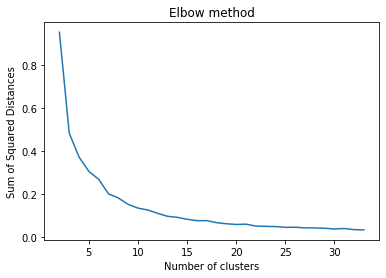

In [5]:
plt.plot(range(2,34), sum_of_squared_distances)
plt.xlabel('Number of clusters')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow method')

In [6]:
# Next we need to decide on the optimum number of optimum values
# For this example we use a number of clusters of 8
km = MiniBatchKMeans(n_clusters = 8)
km.fit_predict(tweets_all)
# We add a line to tweets df for each tweet to its most relevant cluster
tweets_all['cluster'] = km.labels_

In [7]:
# Next we group all the tweets by each cluster to generate a dataframe with each cluster and the number of tweets (weight)
tweets_grouped = tweets_all.groupby('cluster').count()
tweets_grouped = pd.DataFrame(tweets_grouped)
tweets_grouped = tweets_grouped.drop(columns = ['Longitude'])
tweets_grouped = tweets_grouped.rename(columns={"Latitude": "Weight"})
tweets_grouped = tweets_grouped.reset_index()

In [8]:
# Next, we build a dataframe with each centroid and its longitude and latitude position before merging with tweets_grouped
# This generates a merged dataframe with each centroid, its position and number of tweets clustered to it
centers = km.cluster_centers_
centers = pd.DataFrame(centers)
centers = centers.reset_index()
centers = centers.rename(columns={"index":'cluster',0:'Longitude',1:'Latitude'})
merged = pd.merge(tweets_grouped, centers, on='cluster')

In [9]:
# Next we plot these clusters as a heat map, overlayed onto a map of Oxford Street using Folium package
heat_df = merged.loc[:,["Latitude","Longitude","Weight"]]
heat_data = heat_df.values.tolist()
# Create map
oxford_street_map = folium.Map(location=[51.5139448, -0.1532097], zoom_start = 16)
# Add markers
HeatMap(heat_data,radius=13).add_to(oxford_street_map)
oxford_street_map